In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%run functions.py

### Importação dos Dados

In [2]:
images = pd.read_csv("imageMNIST.csv", header=None, decimal=',')
labels = np.array(pd.read_csv("labelMNIST.csv", header=None))
X, zero_cols = zero_col(images)
y = np.asarray(labels)


### Treinamento

In [3]:
input_layer_size = X.shape[1]
hidden_layer_size = np.array([25])#Array com as camadas escondidas e suas respectivas quantidades de neurônios
num_labels = len(np.unique(y))
Lambda = 0.001
alpha = 0.8
nbr_iter = 800

theta, J_history = backpropagation(X, y, num_labels, hidden_layer_size, Lambda, alpha, nbr_iter, regularizada=True)

In [4]:
pred = prediction(X,theta)
print("Training Set Accuracy:",np.sum(pred == y)/len(y)*100,"%")

Training Set Accuracy: 94.02000000000001 %


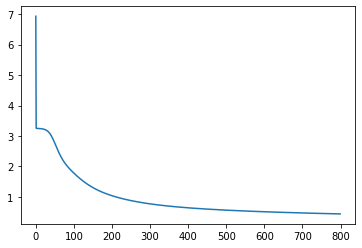

In [5]:
plt.plot(J_history)

## Visualização de $\Theta^{(1)}$

In [6]:
graf_theta = np.delete(theta[0], 0, axis=1)
for i in zero_cols:
    if i >= graf_theta.shape[1]:
        graf_theta = np.append(graf_theta, np.zeros(graf_theta.shape[0]).reshape([graf_theta.shape[0], 1]), axis=1)
    else:
        graf_theta = np.insert(graf_theta, i, np.zeros(graf_theta.shape[0]), axis=1)

# Normalizacao
minimo = np.min(graf_theta, axis=1)
maximo = np.max(graf_theta, axis=1)
for j in range(graf_theta.shape[1]):
    graf_theta[:,j] = (graf_theta[:,j] - minimo) / (maximo - minimo)

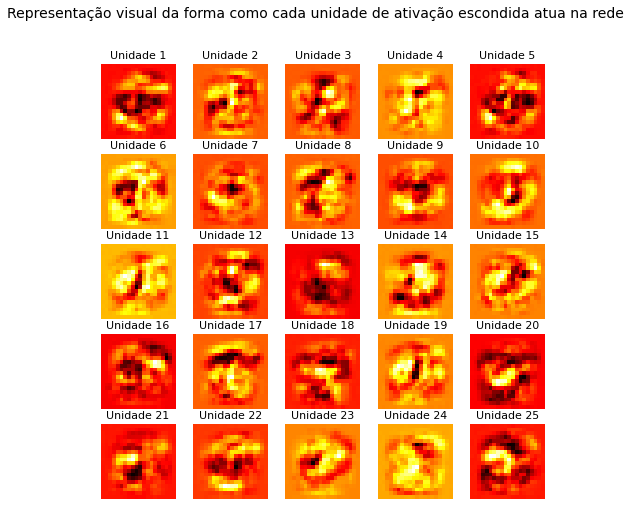

In [8]:
fig, axis = plt.subplots(5, 5,figsize=(8,8))
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(graf_theta[5*i+j,:].reshape(20,20,order="F"),cmap='hot')
        axis[i,j].axis("off")
        axis[i,j].set_title('Unidade {}'.format(str(5*i+j+1)), fontsize=11)
fig.suptitle('Representação visual da forma como cada unidade de ativação escondida atua na rede', fontsize=14)
plt.show()

## Checagem do Gradiente

In [8]:
m = 5
_X = []
_y = []
for i in range(m):
    _X.append(np.random.randint(0,100,3))
    _y.append(np.random.randint(0,4,1))
    
_X = np.array(_X)
_y = np.array(_y)
input_layer_size = _X.shape[1]
hidden_layer_size = np.array([5])
num_labels = 3
Lambda = 0.03
alpha = 0.8
eps = 1e-4
nbr_iter = 1500

grad, grad_approx = checkGradient(_X, _y, num_labels, input_layer_size, hidden_layer_size, Lambda, alpha, eps, regularizada = True)
num, den = 0, 0

num =  (np.linalg.norm(np.asarray(grad) - np.asarray(grad_approx)))
den =  (np.linalg.norm(np.asarray(grad)) + np.linalg.norm(np.asarray(grad_approx)))

diferenca = num/den
if diferenca < eps:
    print("O Gradiente está certo - A diferença entre o grad e o grad_approx é: " + str(diferenca))
else:
    print("O Gradiente está errado - A diferença entre o grad e o grad_approx é: " + str(diferenca))


O Gradiente está certo - A diferença entre o grad e o grad_approx é: 5.898047661125283e-07


## Gradiente Conjugado

In [9]:
# Gradiente Conjugado
m = 20
_X = []
_y = []
for i in range(m):
    _X.append(np.random.randint(0,100,3))
    _y.append(np.random.randint(0,4,1))
    
_X = np.array(_X)
_y = np.array(_y)

input_layer_size = _X.shape[1]
hidden_layer_size = np.array([5])
num_labels = len(np.unique(_y))
#[0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
Lambda = 1
alpha = 0.8
nbr_iter = 400

theta, J_history, res = gradientConjugate(_X, _y, alpha, nbr_iter, Lambda, input_layer_size, hidden_layer_size, num_labels, regularizada = True)
print(res)


      fun: 1.29504112270264
 hess_inv: array([[ 1.92901887e+03, -1.04210754e+01, -1.53929124e+01, ...,
        -3.23231016e-01, -1.43275835e+00,  4.51661648e+00],
       [-1.04210754e+01,  3.30477428e+00, -2.24638077e-01, ...,
        -2.29659824e-01,  8.68165407e-02, -5.06977833e-02],
       [-1.53929124e+01, -2.24638077e-01,  2.32540620e-01, ...,
         2.66040387e-02,  1.75921478e-02, -3.00148892e-02],
       ...,
       [-3.23231016e-01, -2.29659824e-01,  2.66040387e-02, ...,
         6.49078263e+00,  5.39228091e-01, -3.34360734e+00],
       [-1.43275835e+00,  8.68165407e-02,  1.75921478e-02, ...,
         5.39228091e-01,  1.63982341e+01, -1.91891005e-01],
       [ 4.51661648e+00, -5.06977833e-02, -3.00148892e-02, ...,
        -3.34360734e+00, -1.91891005e-01,  1.48971197e+01]])
      jac: array([-4.47034836e-08, -4.90248203e-06,  1.49011612e-08, -6.12437725e-06,
       -4.02331352e-07, -1.63912773e-06, -2.84612179e-06, -2.80141830e-06,
        7.45058060e-08,  2.53319740e-06,  5

In [10]:
_theta = reshapeTheta(res.x, input_layer_size, hidden_layer_size, num_labels)
pred = prediction(_X,_theta)
print("Training Set Accuracy:",np.sum(pred == _y.T)/len(_y)*100,"%")


Training Set Accuracy: 45.0 %
